In [45]:
# step 1: import the libraries and upload the dataset 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from lime import lime_tabular
from sklearn.inspection import permutation_importance
#below is a new package needed for this lab
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import OneHotEncoder

import os

os.chdir("/Users/lucaslisman/Desktop/DS 3001/")
import seaborn as sns

In [46]:
# open the dataset.csv file 
music = pd.read_csv('dataset.csv')
# inspect the types of each column
music.dtypes

Unnamed: 0            int64
track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object

In [47]:
music = music[(music['track_genre'] == 'blues') |  (music['track_genre'] == 'disney') | (music['track_genre'] == 'hip-hop') | (music['track_genre'] == 'pop')]

In [48]:
# check how many nas 
music.isna().sum()
# not too many nas, so we can drop them 
music = music.dropna()

/var/folders/gz/7h0l2_4j6fld7vp7x2k94bhr0000gn/T/ipykernel_3121/4104224432.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr =music.corr()


<Axes: >

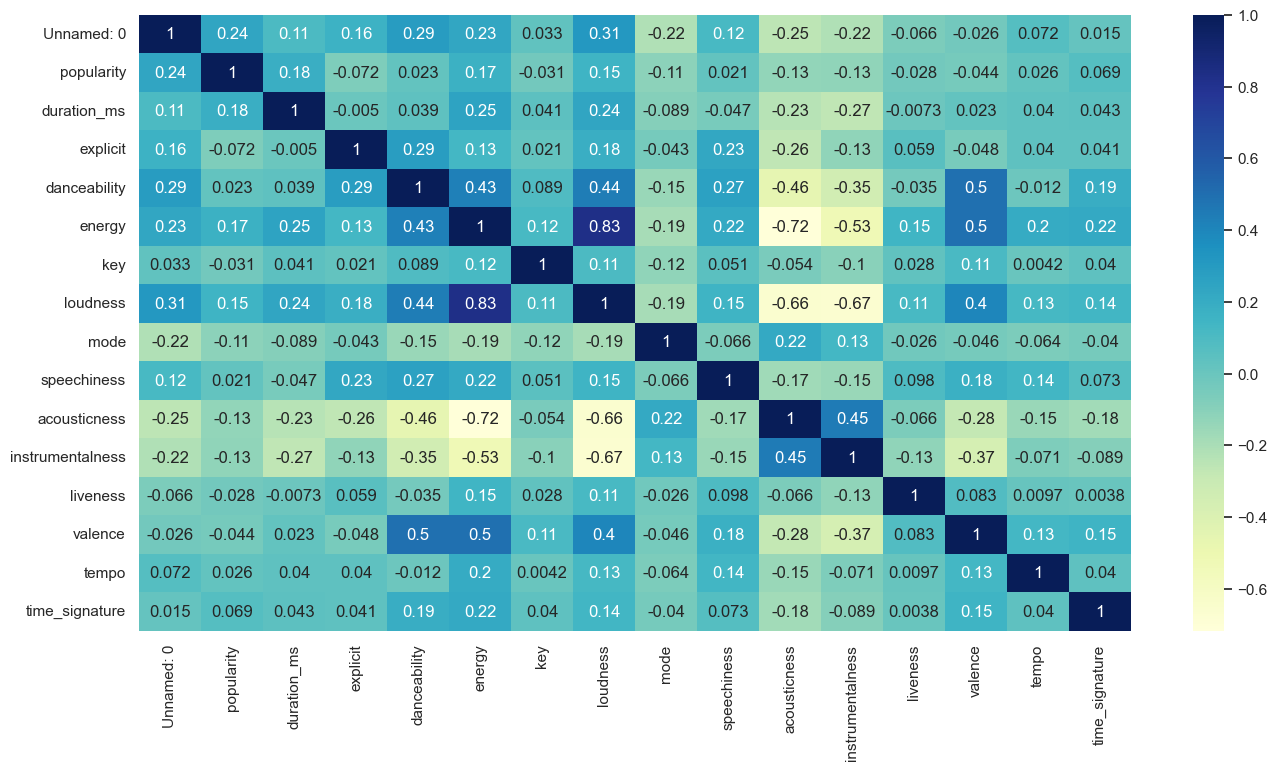

In [49]:
#Correlation
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
corr =music.corr()
sns.heatmap(corr,annot=True, cmap="YlGnBu")

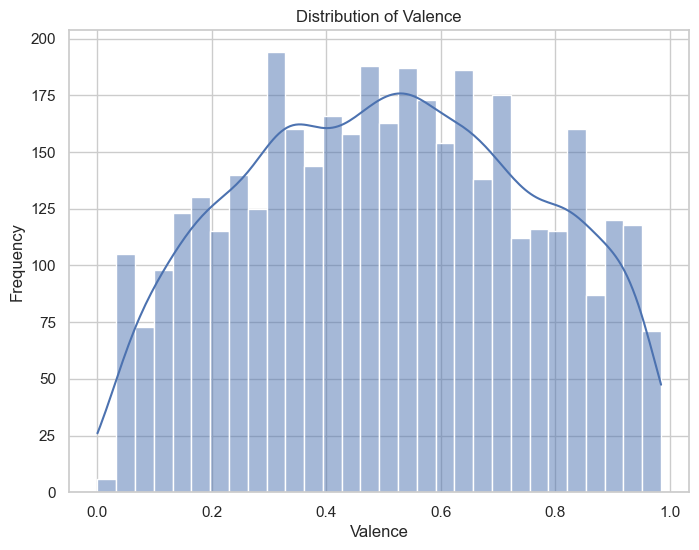

In [50]:
# Distribution of the target variable (danceability)
plt.figure(figsize=(8, 6))
sns.histplot(music["valence"], bins=30, kde=True)
plt.title("Distribution of Valence")
plt.xlabel("Valence")
plt.ylabel("Frequency")
plt.show()

                                 Numeric Features Distribution                                  


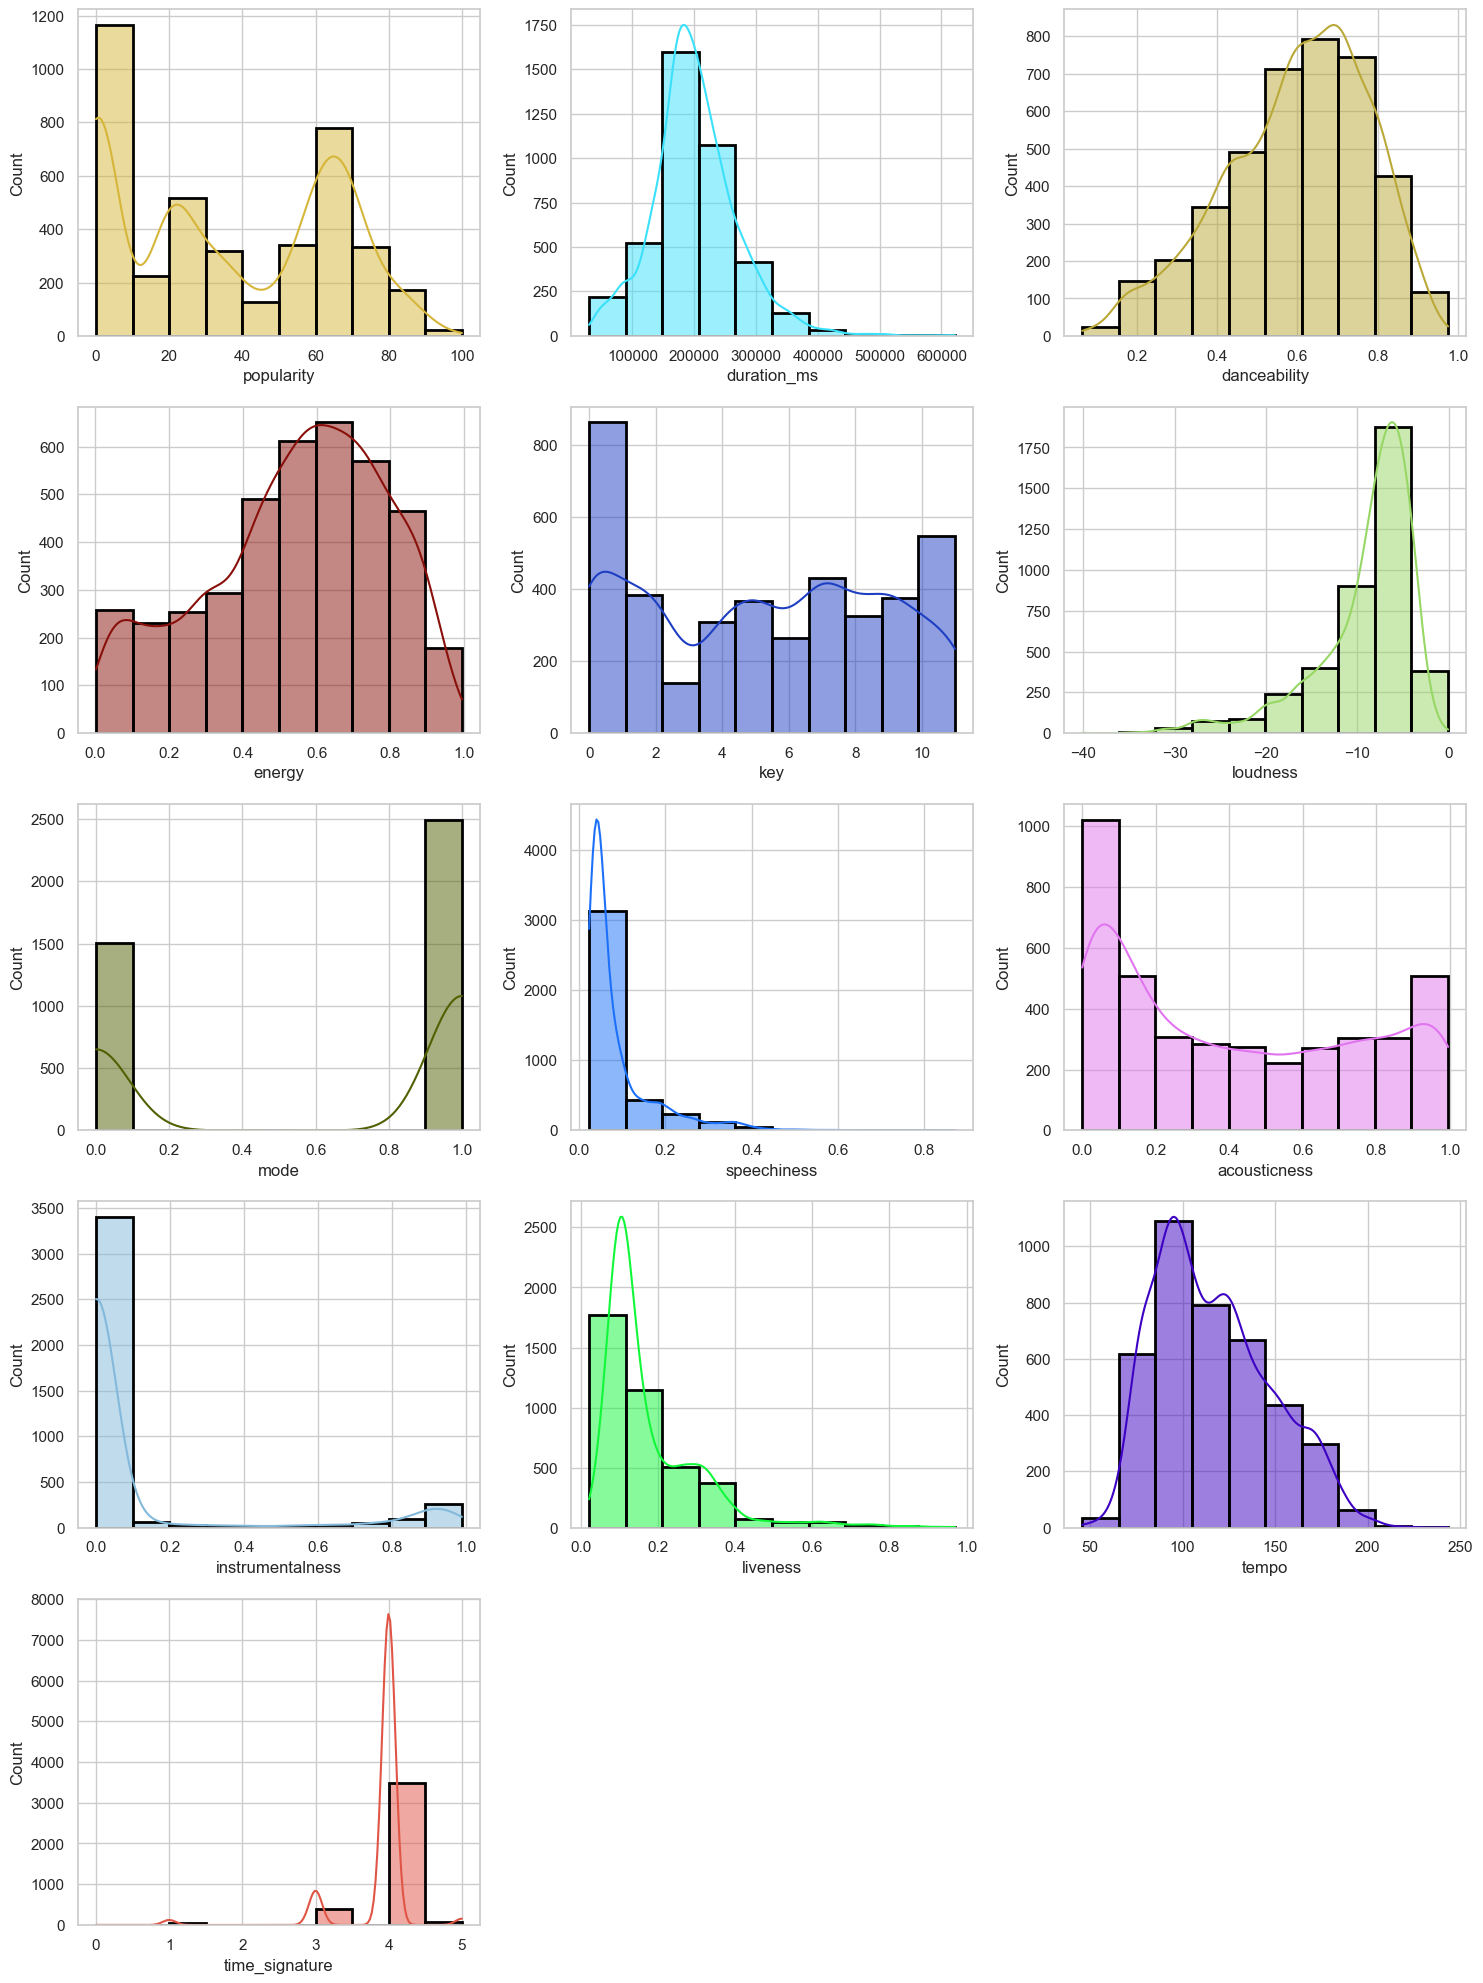

In [51]:
#Numeric Feature Distribution

import math


target_column = 'valence'
numerical_features = music.select_dtypes(include=['int64', 'float64']).columns
numerical_features = numerical_features.drop(target_column)
# drop unnamed column
numerical_features = numerical_features.drop('Unnamed: 0')


print('\033[1mNumeric Features Distribution'.center(100))

# Define number of subplots per row
subplots_per_row = 3
num_rows = math.ceil(len(numerical_features) / subplots_per_row)

plt.figure(figsize=[15, 4 * num_rows])

for i, feature in enumerate(numerical_features):
    plt.subplot(num_rows, subplots_per_row, i + 1)
    sns.histplot(
        music[feature],
        kde=True,  # Add a kernel density estimate
        color=list(np.random.randint([255, 255, 255]) / 255),
        edgecolor="black", 
        linewidth=2,
        bins=10
    )

plt.tight_layout()
plt.show()


In [52]:
# lets fix some of the columns values --> example some of the track names are not legible
# lets remove the ones that are not in english, with any letters that contain special symbols 
# in another language other than english 
music = music[music['track_name'].str.contains('^[a-zA-Z ]+$')]
music['track_name'].value_counts()
# lets drop track_id because it is just a bunch of letters 
music = music.drop(['track_id'], axis = 1)
# also remove the unnamed column
music = music.drop(['Unnamed: 0'], axis = 1)
# lets also drop album name because this wont really contribute to danceability 
music = music.drop(['album_name'], axis = 1)
# lets also drop artists since we dont have any tell about the artists fame 
music = music.drop(['artists'], axis = 1)
# lets also drop explicit because this won't really contribute to danceability
music = music.drop(['track_name'], axis = 1)
# we want to be able to predict danceability of the track, so maybe we can add this in later 


In [53]:

music.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
8000,77,230613,False,0.509,0.448,4,-7.552,0,0.0357,0.00713,0.0137,0.2440,0.221,156.909,3,blues
8001,79,208760,False,0.636,0.676,2,-3.442,1,0.0263,0.08070,0.0000,0.0831,0.273,113.980,4,blues
8003,84,232106,False,0.743,0.446,4,-7.807,0,0.0683,0.00390,0.1180,0.3370,0.278,123.596,4,blues
8004,76,225026,False,0.572,0.214,7,-15.625,1,0.0293,0.64900,0.1290,0.1250,0.485,95.542,4,blues
8006,1,268040,False,0.270,0.577,0,-8.195,1,0.0573,0.75500,0.1230,0.1390,0.362,170.254,4,blues


In [54]:
#Subset by Genre
blues = music[music["track_genre"] == "blues"]
country = music[music["track_genre"] == "country"]
disney = music[music["track_genre"] == "disney"]
hiphop = music[music["track_genre"] == "hip-hop"]
pop = music[music["track_genre"] == "pop"]

In [55]:
blues = blues.drop(['track_genre'], axis = 1)
country = country.drop(['track_genre'], axis = 1)
disney = disney.drop(['track_genre'], axis = 1)
hiphop = hiphop.drop(['track_genre'], axis = 1)
pop = pop.drop(['track_genre'], axis = 1)

In [56]:
#View blues genre
blues.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
8000,77,230613,False,0.509,0.448,4,-7.552,0,0.0357,0.00713,0.0137,0.2440,0.221,156.909,3
8001,79,208760,False,0.636,0.676,2,-3.442,1,0.0263,0.08070,0.0000,0.0831,0.273,113.980,4
8003,84,232106,False,0.743,0.446,4,-7.807,0,0.0683,0.00390,0.1180,0.3370,0.278,123.596,4
8004,76,225026,False,0.572,0.214,7,-15.625,1,0.0293,0.64900,0.1290,0.1250,0.485,95.542,4
8006,1,268040,False,0.270,0.577,0,-8.195,1,0.0573,0.75500,0.1230,0.1390,0.362,170.254,4


In [57]:
#View country genre
country.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature


In [58]:
#View disney genre
disney.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
26000,58,251520,False,0.530,0.584,0,-11.891,1,0.2180,0.2740,0.000000,0.158,0.575,81.854,4
26002,70,195493,False,0.274,0.144,5,-14.516,1,0.0482,0.9200,0.000388,0.290,0.302,61.551,5
26005,52,140160,False,0.270,0.623,4,-9.841,1,0.0930,0.0972,0.349000,0.267,0.463,157.240,3
26006,56,165533,False,0.460,0.574,4,-7.414,0,0.1120,0.3180,0.000000,0.100,0.370,67.697,4
26008,60,84720,False,0.686,0.379,5,-15.243,1,0.2230,0.8560,0.000000,0.103,0.923,137.953,4


In [59]:
#View hiphop genre
hiphop.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
51000,83,177391,False,0.860,0.541,1,-6.510,0,0.0325,0.16500,0.163000,0.0663,0.952,114.984,4
51001,83,170387,False,0.768,0.487,4,-8.936,0,0.0431,0.24000,0.000000,0.1750,0.722,137.034,4
51002,82,148188,False,0.711,0.702,5,-10.048,1,0.2330,0.00487,0.016300,0.0932,0.674,180.219,4
51003,77,206060,False,0.796,0.572,8,-7.030,0,0.0545,0.41600,0.000025,0.0975,0.304,98.967,4
51005,75,131077,False,0.847,0.558,8,-5.855,0,0.0663,0.32500,0.000000,0.1350,0.495,98.062,4


In [60]:
#View pop genre
pop.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
81000,91,200040,False,0.514,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,4
81001,74,200120,False,0.535,0.765,1,-7.862,0,0.0444,0.05400,0.000000,0.0921,0.373,191.827,4
81002,83,177391,False,0.860,0.541,1,-6.510,0,0.0325,0.16500,0.163000,0.0663,0.952,114.984,4
81003,96,184613,True,0.733,0.690,9,-5.529,0,0.0427,0.06350,0.000001,0.1050,0.310,116.992,4
81004,90,230453,True,0.679,0.587,7,-7.015,1,0.2760,0.14100,0.000006,0.1370,0.486,186.003,4


## Blues Model Building (Happy)

In [63]:
# lets separate our X and Y variables for our random forest 
# we will use the danceability as our target variable
y = blues['valence']
X = blues.drop(['valence'], axis = 1)

In [81]:
# right now danceability is on a 0-1.0 scale, lets change it to a more condensed scale 
# lets use either not danceable or danceable 
# the cutoff is 0-0.6 and then 0.6-1.0

# lets create a function that will change the danceability to either 0 or 1
# and our threshold will be 0.6 because this is the original mean of the danceability
def valence_changeBH(valence):
    if valence >= 0.7:
        return 1
    else:
        return 0

# lets apply this function to our y variable
y = y.apply(valence_changeBH)


In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify= y, random_state=21) 
# test size = 30%

In [78]:
#Check the output
print(y_train.value_counts())
print(y_test.value_counts())

0    302
1    181
Name: valence, dtype: int64
0    129
1     78
Name: valence, dtype: int64


In [79]:
random_grid = {'n_estimators': [500], #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
            'max_features': [5], #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification it is sqrt(p) where p is number of variables in x and regression it is simply p.
            'bootstrap': [True], #<-Whether bootstrap samples are used when building trees
            'max_samples' : [150],  #<- Size of sample to draw each time.
            'min_samples_leaf': [10], #<- Minimum numbers of data points in terminal nodes.
            'max_leaf_nodes': [None], #<- Maximum number of terminal nodes trees in the forest can have. 
            'max_depth': [None], #<-The maximum depth of the tree
            'min_samples_split': [None], #<-The minimum number of samples required to split an internal node
            'oob_score': True, #<-Whether to use out-of-bag samples to estimate the generalization score
            'warm_start': True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
                }

In [70]:
print('max_features = ' + str(np.sqrt(X.shape[1]))) #3.6 --> originally was at 11 but after removing track_genre, it decreased due to less columns

RFC = RandomForestClassifier(n_estimators=1000, #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
                max_features= 4, #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p).
                bootstrap= True, #<-Whether bootstrap samples are used when building trees
                max_samples = 100,  #<- Size of sample to draw each time.
                min_samples_leaf= 5, #<- Minimum numbers of data points in terminal nodes.
                max_leaf_nodes= None, #<- Maximum number of terminal nodes trees in the forest can have. 
                max_depth= None, #<-The maximum depth of the tree
                oob_score =True, #<-Whether to use out-of-bag samples to estimate the generalization score
            warm_start =True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
            random_state= 1984,
            n_jobs= -1, #<- Number of cores to use for parallel processing (-1 will use all available)
            verbose=True) #<- Whether to print progress messages to stdout.

bluesH_RF= RFC.fit(X_train,y_train)

# finished in 22 seconds

max_features = 3.7416573867739413


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.1s finished


In [71]:
print('OOB error rate: ' + str(1-bluesH_RF.oob_score_))

OOB error rate: 0.17805383022774324


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s


False Positive Rate: 0.0596
True Positive Rate: 0.7735
Precision: 0.8861


[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


Accuracy: 0.8778


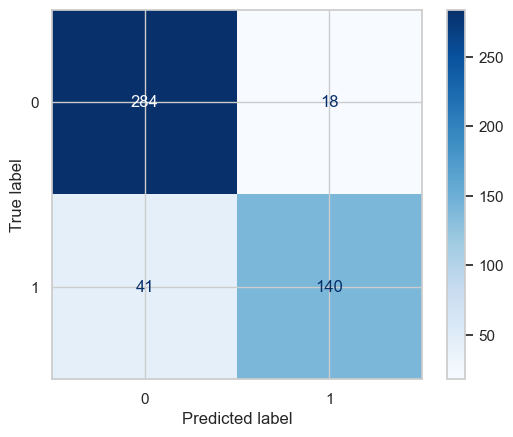

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Generate predictions on the training set
y_pred_train = bluesH_RF.predict(X_train)

# Obtain the confusion matrix
cm = confusion_matrix(y_train, y_pred_train)

# Calculate false positive rate (FPR) and true positive rate (TPR)
fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1])
tpr = cm[1, 1] / (cm[1, 0] + cm[1, 1])
precision = cm[1, 1] / (cm[0, 1] + cm[1, 1])

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=bluesH_RF.classes_).plot(cmap='Blues')

# Display FPR and TPR
print(f"False Positive Rate: {fpr:.4f}")
print(f"True Positive Rate: {tpr:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Accuracy: {bluesH_RF.score(X_train, y_train):.4f}")

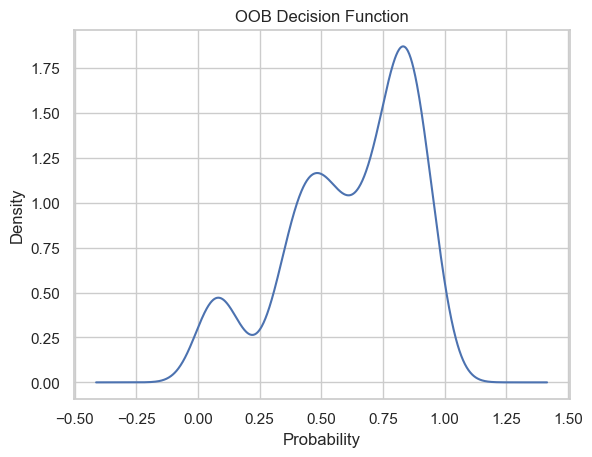

In [74]:
# View the percentage of trees that voted for 
# each data point to be in each class -- either below or above 0.60
xx = pd.DataFrame(bluesH_RF.oob_decision_function_)


#Creating a density plot of the positive class probabilities 
xx[0].plot(kind='density')
plt.title("OOB Decision Function")
plt.xlabel("Probability")
plt.show()

In [75]:
#determining feature importance

np.argmax(bluesH_RF.oob_decision_function_,axis=1)
print(pd.DataFrame(bluesH_RF.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False))

                  importance
danceability        0.281213
duration_ms         0.126399
energy              0.123341
speechiness         0.068237
acousticness        0.065513
key                 0.062625
loudness            0.057242
tempo               0.055949
popularity          0.054662
liveness            0.054545
instrumentalness    0.041065
mode                0.006093
time_signature      0.002770
explicit            0.000346


## Blues Model Building (Sad)

In [80]:
# lets separate our X and Y variables for our random forest 
# we will use the danceability as our target variable
y = blues['valence']
X = blues.drop(['valence'], axis = 1)

In [82]:
# right now danceability is on a 0-1.0 scale, lets change it to a more condensed scale 
# lets use either not danceable or danceable 
# the cutoff is 0-0.6 and then 0.6-1.0

# lets create a function that will change the danceability to either 0 or 1
# and our threshold will be 0.6 because this is the original mean of the danceability
def valence_changeBS(valence):
    if valence <= 0.3:
        return 1
    else:
        return 0

# lets apply this function to our y variable
y = y.apply(valence_changeBS)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify= y, random_state=21) 
# test size = 30%

In [84]:
#Check the output
print(y_train.value_counts())
print(y_test.value_counts())

1    301
0    182
Name: valence, dtype: int64
1    129
0     78
Name: valence, dtype: int64


In [85]:
random_grid = {'n_estimators': [500], #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
            'max_features': [5], #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification it is sqrt(p) where p is number of variables in x and regression it is simply p.
            'bootstrap': [True], #<-Whether bootstrap samples are used when building trees
            'max_samples' : [150],  #<- Size of sample to draw each time.
            'min_samples_leaf': [10], #<- Minimum numbers of data points in terminal nodes.
            'max_leaf_nodes': [None], #<- Maximum number of terminal nodes trees in the forest can have. 
            'max_depth': [None], #<-The maximum depth of the tree
            'min_samples_split': [None], #<-The minimum number of samples required to split an internal node
            'oob_score': True, #<-Whether to use out-of-bag samples to estimate the generalization score
            'warm_start': True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
                }

In [87]:
print('max_features = ' + str(np.sqrt(X.shape[1]))) #3.6 --> originally was at 11 but after removing track_genre, it decreased due to less columns

RFC = RandomForestClassifier(n_estimators=1000, #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
                max_features= 4, #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p).
                bootstrap= True, #<-Whether bootstrap samples are used when building trees
                max_samples = 100,  #<- Size of sample to draw each time.
                min_samples_leaf= 5, #<- Minimum numbers of data points in terminal nodes.
                max_leaf_nodes= None, #<- Maximum number of terminal nodes trees in the forest can have. 
                max_depth= None, #<-The maximum depth of the tree
                oob_score =True, #<-Whether to use out-of-bag samples to estimate the generalization score
            warm_start =True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
            random_state= 1984,
            n_jobs= -1, #<- Number of cores to use for parallel processing (-1 will use all available)
            verbose=True) #<- Whether to print progress messages to stdout.

bluesS_RF= RFC.fit(X_train,y_train)

# finished in 22 seconds

max_features = 3.7416573867739413


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.3s finished


In [88]:
print('OOB error rate: ' + str(1-bluesS_RF.oob_score_))

OOB error rate: 0.19461697722567284


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


False Positive Rate: 0.2802
True Positive Rate: 0.9535
Precision: 0.8491
Accuracy: 0.8654


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


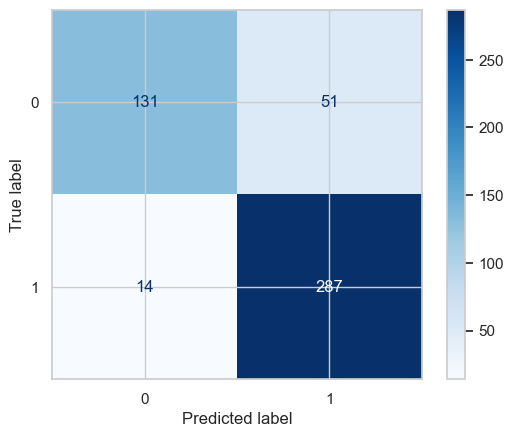

In [89]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Generate predictions on the training set
y_pred_train = bluesH_RF.predict(X_train)

# Obtain the confusion matrix
cm = confusion_matrix(y_train, y_pred_train)

# Calculate false positive rate (FPR) and true positive rate (TPR)
fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1])
tpr = cm[1, 1] / (cm[1, 0] + cm[1, 1])
precision = cm[1, 1] / (cm[0, 1] + cm[1, 1])

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=bluesH_RF.classes_).plot(cmap='Blues')

# Display FPR and TPR
print(f"False Positive Rate: {fpr:.4f}")
print(f"True Positive Rate: {tpr:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Accuracy: {bluesS_RF.score(X_train, y_train):.4f}")

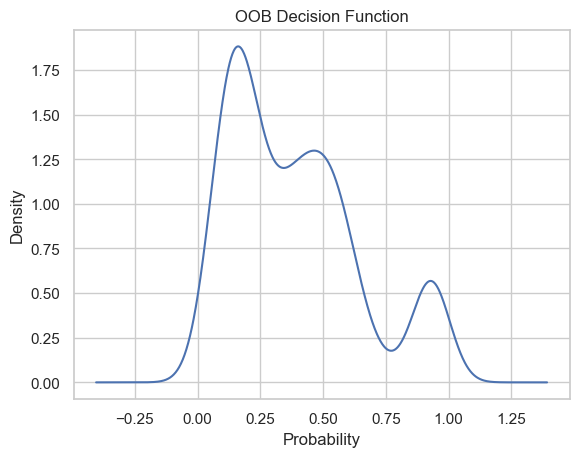

In [90]:
# View the percentage of trees that voted for 
# each data point to be in each class -- either below or above 0.60
xx = pd.DataFrame(bluesH_RF.oob_decision_function_)


#Creating a density plot of the positive class probabilities 
xx[0].plot(kind='density')
plt.title("OOB Decision Function")
plt.xlabel("Probability")
plt.show()

In [91]:
#determining feature importance

np.argmax(bluesH_RF.oob_decision_function_,axis=1)
print(pd.DataFrame(bluesH_RF.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False))

                  importance
danceability        0.279090
duration_ms         0.150213
energy              0.106348
speechiness         0.065079
acousticness        0.063825
popularity          0.063421
liveness            0.060749
key                 0.055238
loudness            0.050207
tempo               0.050067
instrumentalness    0.046146
mode                0.006648
time_signature      0.002972
explicit            0.000000
